In [2]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt
import os
import pandas as pd
%matplotlib inline

In [8]:
img = cv2.imread('kaggle/input/oral-diseases/Calculus/Calculus/(1).jpg')
img.shape

(408, 612, 3)

In [9]:
path = 'kaggle/input/oral-diseases/'

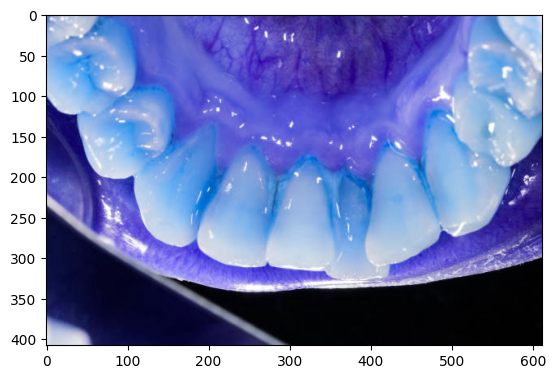

In [10]:
plt.imshow(img)

In [11]:
# Applying a gray filter to the image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(408, 612)

In [12]:
# Loading the smile cascade classifier
smile_cascade = cv2.CascadeClassifier('kaggle/input/haar-cascades-for-face-detection/haarcascade_smile.xml')
smile = smile_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5, minSize = (30, 30))
for (x, y, w, h) in smile:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
output_path = 'kaggle/working/image_with_teeth.jpg'
cv2.imwrite(output_path, img)
print('Image with detected teeth saved to:', output_path)

Image with detected teeth saved to: kaggle/working/image_with_teeth.jpg


In [13]:
path_to_data = 'kaggle/input/oral-diseases'

In [14]:
# Scanning the directory using os python function to collect
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [15]:
# Dropping the directory we won't be using
img_dirs = [img_dir for img_dir in img_dirs if not img_dir.endswith('Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset')]

In [16]:
img_dirs

['kaggle/input/oral-diseases/Gingivitis',
 'kaggle/input/oral-diseases/Mouth Ulcer',
 'kaggle/input/oral-diseases/Tooth Discoloration',
 'kaggle/input/oral-diseases/hypodontia',
 'kaggle/input/oral-diseases/Data caries',
 'kaggle/input/oral-diseases/Calculus']

In [17]:
# Collecting file directories into a dictionary
oral_disease_file_names_dict = {}

for img_dir in img_dirs:
    disease_name = img_dir.split('/')[-1]
    oral_disease_file_names_dict[disease_name] = []
    for root, dirs, files in os.walk(img_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')): 
                file_path = os.path.join(root, file)
                oral_disease_file_names_dict[disease_name].append(file_path)

In [19]:
# Transforming the image to improve detection
def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs[0] *= 0
    imArray_H = pywt.waverec2(coeffs, mode)
    imArray_H = np.clip(imArray_H, 0, 255)
    imArray_H = np.uint8(imArray_H)
    return imArray_H

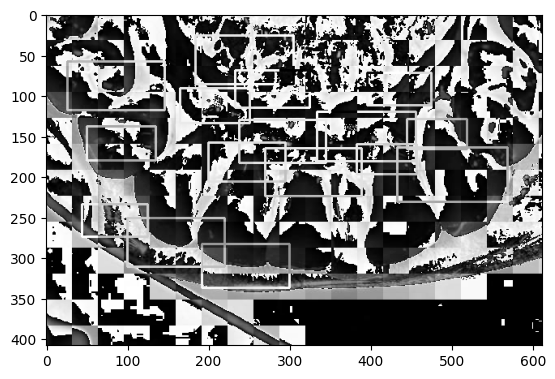

In [20]:
im_har = w2d(img,'db1',5)
plt.imshow(im_har, cmap = 'gray')

In [23]:
# Creating the labels based on directories
class_dict = {}
count = 0
for disease_name in oral_disease_file_names_dict.keys():
    class_dict[disease_name] = count
    count = count + 1
class_dict

{'Gingivitis': 0,
 'Mouth Ulcer': 1,
 'Tooth Discoloration': 2,
 'hypodontia': 3,
 'Data caries': 4,
 'Calculus': 5}

In [24]:
# Creating a stacked version of the image - original and distorted one
x, y = [], []
for disease_name, training_files in oral_disease_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scaled_orig_img = cv2.resize(img, (40, 30))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (40, 30))
        stacked_img = np.vstack((scaled_orig_img.reshape(40*30*3,1),scaled_orig_img.reshape(40*30*3,1)))
        x.append(stacked_img)
        y.append(class_dict[disease_name])

In [27]:
# Converting to float and reshaping X
x = np.array(x).reshape(len(x),7200).astype(float)
x.shape

(11403, 7200)

In [28]:
x[0]

array([ 90., 100., 121., ...,  72.,  80., 156.])

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

In [57]:
# Training the initial SVC model
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)

0.7032620133286566

In [31]:
len(x_test)

2851

In [32]:
# Printing a detailed report
print(classification_report(y_test, pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       549
           1       0.75      0.83      0.79       697
           2       0.68      0.58      0.63       535
           3       0.88      0.60      0.71        89
           4       0.61      0.62      0.62       665
           5       0.68      0.67      0.68       316

    accuracy                           0.70      2851
   macro avg       0.73      0.68      0.70      2851
weighted avg       0.70      0.70      0.70      2851



In [33]:
# Grid search, to try different models with different parameters to find the best fine tuned ones

In [38]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [39]:
param_grid = {
    'svc__kernel': ['rbf', 'linear'],
    'svc__C': [1, 10],
    'svc__gamma': [0.01, 0.1]
}

In [40]:
pipe = make_pipeline(MinMaxScaler(), PCA(n_components=100), SVC())

In [41]:
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

In [42]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(n_components=100)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 10], 'svc__gamma': [0.01, 0.1],
                         'svc__kernel': ['rbf', 'linear']})

Test

In [43]:
# Getting the best hyperparameters
best_params = grid_search.best_params_
print('Best hyperparameters:', best_params)

Best hyperparameters: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [44]:
# Evaluating the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test)
print('Test set accuracy:', test_score)

Test set accuracy: 0.710978603998597


In [55]:
final_mod = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
final_mod.fit(x_train, y_train)
final_mod.score(x_test, y_test)

0.7032620133286566

In [54]:
import joblib

In [56]:
# Saving the final model
joblib.dump(final_mod, 'oraldiseaseclassif.pkl')

['oraldiseaseclassif.pkl']